# Statistical Testing Templates for CPTAC Data

<b>Standard imports for playing with and plotting data frames.</b>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.stats.multitest
#import altair as alt
#alt.renderers.enable('notebook') #Necessary for Altair to work

In [2]:
import CPTAC

Loading CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


In [4]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

#Try Looking at all proteins, not just interacting proteins
all_proteins = list(proteomics.columns.values)

### List of interacting proteins (according to STRING and Uniprot)

In [5]:
#Build the protein list; this may have only a single protein if desired
#protList = ['IRS1', 'IRS2', 'RRAS', 'AKT2', 'NRAS', 'PTEN', 'AKT1', 'MRAS', 'HRAS', 'RPS6KB1', 'PIK3R1', 'PKC', 'MTOR', 'S6K', 'MAPK', 'ERBB3', 'P85A', 'P55G', 'CDK5']
protList = all_proteins

### Test for phosphorylation levels (difference between cancer wildtype and normal wildtype

In [6]:
#List of proteins (will test all phosphorylation sites on these proteins (all proteins) )
phosProtList = protList

In [7]:
sites = phos.columns
p_values = []
site_names = []
gene = 'PIK3CA'

for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, sites)
    if next(isInList, None) is not None:
        phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
        for site in phosphositesdf.columns:
            '''just making sure not to do comparison on mutation column or patient_type column'''
            if (site is not 'Mutation' and site is not 'Patient_Type'):
                sitedf = CPTAC.compare_mutations(phos, site, gene)
                mutateddf = sitedf.loc[sitedf['Mutation'] != 'Wildtype'].dropna(axis=0)
                wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
                '''Split the wildtype datafram into two, cancer wt vs normal wt'''
                cancer_wtdf = wtdf.loc[wtdf['Patient_Type'] == "Tumor"].dropna(axis=0)
                normal_wtdf = wtdf.loc[wtdf['Patient_Type'] == "Normal"].dropna(axis=0)
                '''We do our t-test on these two datframes, comparing phosphorylation levels in cancer wt with normal wt'''
                ttest = scipy.stats.ttest_ind(cancer_wtdf[site], normal_wtdf[site])
                p_values.append(ttest[1])
                site_names.append(site)



#We need to remove all 'nan' p-values and their corresponding site names before passing it in for the fdr correction
indexesToRemove=[]

for index in range(0, len(p_values)):
    if np.isnan(p_values[index]):
        indexesToRemove.append(index)

for rem in range( len(indexesToRemove)-1, -1, -1):
    p_values.pop(indexesToRemove[rem])
    site_names.pop(indexesToRemove[rem])
#p_values and site names have now had all entries removed where the corresponding p-value is 'nan'

print(p_values)
print(site_names)
        


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Seeing significance of P values using bonferroni correction

In [8]:
'''Account for multiple testing by adjusting the threshold p-value according to how many sites we tested (bonferroni correction)'''
threshold_pval = .05/len(site_names)
print("threshold_pval: ", threshold_pval)
bonferonni_corrected_pvals = list()
bonferonni_sig_sites = list()
'''Add all the sites and p-values of the p-values that met our new threshold'''
for ind in range(0, len(p_values)):
    if p_values[ind] <= threshold_pval:
        bonferonni_corrected_pvals.append(p_values[ind])
        bonferonni_sig_sites.append(site_names[ind])
        
        
bf_significant_vals = dict(zip(bonferonni_sig_sites, bonferonni_corrected_pvals))

threshold_pval:  4.974332444585937e-07


### Print signifcant site names and p-values

In [9]:
for key in sorted(bf_significant_vals):
    print(key, bf_significant_vals[key])

print(len(bonferonni_sig_sites))
print(len(bonferonni_corrected_pvals))
print(len(site_names))

AAK1-S637 6.324286959690142e-09
AAMDC-S46 1.2860117530459877e-09
ABCC1-S919 3.978103516455672e-10
ABCC4-T646 3.3339716240887295e-07
ABCF1-S22 1.120415603061415e-08
ABI1-S183 3.484150746848265e-07
ABI1-S225 9.201071920890689e-08
ABI1-T200 1.0250980377661699e-07
ABI2-S233 5.492923064816604e-09
ABI2-S368 9.208527260357612e-15
ABL1-S824 2.690260563591309e-07
ABL1-S828 1.4129997931023366e-07
ABL1-Y204 3.377428195646494e-07
ABL2-S620 4.711964560698288e-07
ABLIM3-S373 7.004252502773108e-09
ABLIM3-S388 1.6366258069924972e-11
ACBD3-S316 2.3335282754396753e-08
ACBD5-S205 3.901772460099619e-11
ACBD5-S209 7.455913976063912e-10
ACIN1-S208 4.530940490349193e-07
ACIN1-S295 4.997440471131578e-11
ACSS2-S267 2.9898570982764384e-07
ACTBL2-T305 4.659623796636697e-07
ACTR8-S132 6.048576358066119e-08
ADAM22-S863 1.4001861598802713e-11
ADAM9-T761 4.806701811686843e-09
ADAR-S825 2.5935950959142862e-08
ADARB1-S26 3.2230054499889892e-09
ADAT1-S191 2.2226222598763145e-08
ADD1-S12 1.2883570534913548e-07
ADD1-S514

FOXO1-S256 6.161319465586026e-09
FOXO1-S276 9.254540429703847e-11
FOXO1-S287 2.6130803226848914e-08
FOXO1-S319 6.5696331741664e-09
FOXO1-S325 6.673800192742767e-08
FOXO1-S329 1.210353485739236e-08
FOXO1-S470 4.761846386781788e-10
FOXO1-T333 2.4434578594380157e-09
FOXO4-S197 8.114590471528235e-10
FOXO4-S241 1.1184288234607409e-08
FOXO4-S262 1.7754436427217837e-08
FRMD6-S375 2.078671981128684e-09
FRMD6-S525 2.4142697515312003e-09
FRMD6-S542 2.0523394367141883e-09
FTSJ3-S335 2.0834320313213915e-07
FTSJ3-S584 3.461836889070988e-11
FTSJ3-S644 3.9478539775735845e-07
FXR1-S406 1.316884037635199e-10
FXR2-S637 3.2352373793304324e-09
FXYD1-S83 1.7424237480649913e-10
GAB1-S547 2.085615303628484e-09
GAB1-S713 1.6928223452416847e-12
GAB2-S210 1.2247392628593951e-07
GAK-S73 5.318829777760213e-09
GAK-S812 3.132718948914306e-07
GAK-S815 3.132718948914306e-07
GAK-S834 1.1953226786594918e-07
GAP43-T217 9.591499618899361e-08
GAPDH-S333 9.220441881556027e-09
GAPVD1-S790 3.997675550084973e-09
GAPVD1-S791 1

PNPLA2-S428 2.8093182731613323e-11
POGZ-T1368 2.3532489938053657e-07
POLD3-S413 1.1864048538266648e-12
POLD3-T411 1.0946391798150202e-12
POLR1C-S258 8.498387010998604e-08
POLR2A-S1826 1.7408468177617723e-07
POLR2A-S1829 3.0700690562411907e-10
POLR2A-S1833 6.546242648694745e-08
POLR2A-S1868 2.3911533761992047e-10
POLR2A-S1875 1.582486549273891e-15
POLR2A-S1882 5.4756429572837794e-14
POLR2A-S1892 2.707832177700674e-08
POLR2A-S1910 7.896054429465963e-08
POLR2A-T1835 8.631500836276839e-11
POLR2A-T1894 3.6855838435869566e-08
POLR3C-T425 1.0979734271411675e-07
POP1-S730 6.544866074730085e-11
POU2F1-S471 3.312346668589117e-08
PPFIBP1-S37 6.839700111302328e-09
PPFIBP2-S387 1.2465647998156101e-07
PPFIBP2-S414 1.0529549150033277e-07
PPIG-S256 7.587737974048472e-08
PPIG-S257 2.1097137232812658e-08
PPIG-S744 5.065924091951933e-10
PPIG-S745 1.7939069834445832e-13
PPIG-T748 6.056408180646197e-10
PPIP5K2-S1021 4.634186372054936e-07
PPL-S14 4.4482790460100935e-12
PPM1K-S248 4.3249623006831976e-10
PPM1

TNS2-T101 2.3182623962575973e-08
TNS2-T1192 6.220107722531277e-10
TNS2-T947 1.5833281131533917e-08
TNS2-Y493 2.1999480098504053e-09
TNXB-S581 1.618386945343854e-08
TOE1-S5 1.8580250896196333e-08
TOM1L1-S323 1.2969153192603369e-07
TOM1L2-S423 4.99234713127612e-08
TOMM34-S186 2.4444057770829e-07
TOP2A-S1469 1.3305140041479837e-07
TOP2A-S1471 3.854838391228205e-13
TOP2A-S1474 5.055042414486205e-13
TOP2A-T1343 2.964499556054283e-08
TOP2A-T1470 2.2591058217499733e-11
TOP2B-S1336 5.6321155607860964e-08
TOR1AIP1-S79 3.597855964426587e-11
TP53BP1-S1099 1.0603444371001362e-09
TP53BP1-S1106 1.9784497829570255e-07
TP53BP1-S1109 3.0168401379828124e-08
TP53BP1-S1435 1.0254896903383379e-07
TP53BP1-S1683 1.2600472970133184e-10
TP53BP1-S512 1.2366203607254395e-12
TP53BP1-S525 8.018713421703928e-13
TP53BP1-S665 1.0409827702388634e-07
TP53BP1-S667 1.9745859062474481e-10
TP53BP1-S679 1.7302153630616407e-07
TP53BP1-T1643 3.934491397964017e-08
TP53BP1-T1653 6.399351803259543e-11
TPI1-S117 9.757771710479159

### Use FDR Correction

In [10]:
pvalues = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[1]         
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[0]

significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]
significant_vals = dict(zip(significant_sites, significant_pvalues))

print("\nSignificant values (FDR): ", significant_vals)

print(len(significant_sites))


Significant values (FDR):  {'AAAS-S495': 0.01078652530545093, 'AAAS-S541': 0.02920732552853316, 'AAED1-S12': 0.005840610154422571, 'AAK1-S637': 1.9705270553013463e-07, 'AAK1-S676': 0.002229827871654061, 'AAK1-S682': 0.027129766811171383, 'AAK1-S731': 9.32149934322727e-06, 'AAK1-S846': 0.0020171200286047916, 'AAK1-T389': 0.013853442023179565, 'AAK1-T694': 0.006591086659517222, 'AAMDC-S46': 5.018041823337364e-08, 'AARS-S555': 0.014013365694681777, 'AATF-S316': 0.0030266059151180464, 'AATF-S320': 1.4905640833845401e-05, 'AATF-S321': 5.607187881844655e-05, 'ABCB1-S741': 0.00249150499514028, 'ABCC1-S915': 0.018218134647188598, 'ABCC1-S918': 9.456984982587796e-06, 'ABCC1-S919': 1.8350759663150908e-08, 'ABCC1-S921': 4.5325294438261625e-05, 'ABCC1-S930': 0.00022711508171235976, 'ABCC1-T931': 0.00715837758948775, 'ABCC1-Y920': 0.0009099873137218124, 'ABCC3-S884': 0.024226352520105264, 'ABCC3-T890': 0.033221089195013515, 'ABCC4-S665': 0.00986215316040924, 'ABCC4-T646': 5.784869528170253e-06, 'A

### Plot phosphorylation levels and gene mutation

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


[Text(0, 0.5, 'Phosphoproteomics'), Text(0.5, 0, 'Somatic Gene Mutation')]

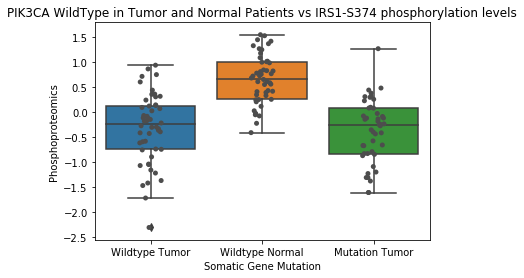

In [11]:
#Specify the gene and the site; you may use a string to specify the site or reference the significant results above

gene = 'PIK3CA'

site="IRS1-S374"

#Build the dataframe for plotting
genedf = CPTAC.compare_mutations(phos, site, gene)

'''First get all the instances where mutation != wildtype'''
mutationdf = genedf.loc[genedf['Mutation'] != 'Wildtype'].drop('Mutation', axis = 1).dropna(axis=0)

'''Get all wildtype cases, change name of patient type to wildtype tumor or wildtype normal depending on patienttype'''
genedf = genedf.loc[genedf['Mutation'] == 'Wildtype'].drop('Mutation', axis = 1).dropna(axis=0)
for i, row in genedf.iterrows():
    id = i
    if row['Patient_Type'] == 'Tumor':
        genedf.set_value(id,'Patient_Type','Wildtype Tumor')
    if row['Patient_Type'] == 'Normal':
        genedf.set_value(id,'Patient_Type','Wildtype Normal')

'''Change name of patient type in mutationdf to mutation tumor'''        
for i, row in mutationdf.iterrows():
    id = i
    mutationdf.set_value(id,'Patient_Type','Mutation Tumor')

'''Merge the two dataframes'''
frames = [genedf, mutationdf]
merged = pd.concat(frames)

'''Plot the data, comparing wildtype cancer, wildtype normal, and mutated cancer'''
phos_boxplot = sns.boxplot(data=merged, x="Patient_Type",y=site)
phos_boxplot.set_title(gene + " WildType in Tumor and Normal Patients vs " + site + " phosphorylation levels")
phos_boxplot = sns.stripplot(data=merged, x="Patient_Type", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Phosphoproteomics")
